In [14]:
# Cell 1: Install and import libraries

# If needed, install scikit-learn (Colab usually has it)
!pip install scikit-learn pandas numpy matplotlib

# Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


In [15]:
# Cell 2 (fixed): Try multiple encodings to load the CSV safely

file_path = "ds.csv"

encodings_to_try = ["utf-8", "latin1", "ISO-8859-1", "cp1252"]

for enc in encodings_to_try:
    try:
        print(f"Trying encoding: {enc}")
        df = pd.read_csv(file_path, encoding=enc)
        print(f"Successfully loaded with encoding: {enc}")
        break
    except Exception as e:
        print(f"Failed with {enc}: {e}")

# Preview the data
display(df.head())
print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())


Trying encoding: utf-8
Failed with utf-8: 'utf-8' codec can't decode byte 0x9d in position 57: invalid start byte
Trying encoding: latin1
Successfully loaded with encoding: latin1


,phrase,sentiment
0,"""I love spending time with my family.""",positive
1,"""Sunshine always brightens my day.""",positive
2,"""Helping others is so rewarding.""",positive
3,"""A good book can transport you to another world.""",positive
4,"""The smell of freshly baked bread is amazing.""",positive



Dataset shape: (3479, 2)

Columns: ['phrase', 'sentiment']


In [16]:
# Count how many samples per class
print("Class distribution:")
print(df['sentiment'].value_counts())

# Percentages
print("\nClass distribution (percentages):")
print(df['sentiment'].value_counts(normalize=True) * 100)


Class distribution:
sentiment
positive     1290
negative     1129
neutral      1059
positive'       1
Name: count, dtype: int64

Class distribution (percentages):
sentiment
positive     37.079621
negative     32.451854
neutral      30.439782
positive'     0.028744
Name: proportion, dtype: float64


In [17]:
# Create a mapping dictionary
label_map = {
    "positive": "Hot",
    "positive'": "Hot",   # Fix stray positive'
    "negative": "Dead",
    "neutral": "Cold"
}

# Apply mapping
df['sentiment'] = df['sentiment'].replace(label_map)

# Verify the change
print("Updated class distribution:")
print(df['sentiment'].value_counts())


Updated class distribution:
sentiment
Hot     1291
Dead    1129
Cold    1059
Name: count, dtype: int64


In [18]:
# Cell 3: Prepare data for ML

# Features (text)
X = df['phrase']

# Labels (Hot, Cold, Dead)
y = df['sentiment']

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 2783
Testing samples: 696


In [20]:
# Cell 5: TF-IDF Vectorization

tfidf = TfidfVectorizer(
    max_features=5000,        # limit vocabulary (optional)
    ngram_range=(1,2),        # unigrams + bigrams
    stop_words=None           # we keep stopwords for sentiment tasks
)

# Fit on training data and transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)

print("TF-IDF training shape:", X_train_tfidf.shape)
print("TF-IDF testing shape:", X_test_tfidf.shape)


TF-IDF training shape: (2783, 5000)
TF-IDF testing shape: (696, 5000)


In [21]:
# Cell 6: Train Logistic Regression

# Initialize model
lr_model = LogisticRegression(
    max_iter=500,       # increase iterations to ensure convergence
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42
)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

print("Model training completed!")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Model training completed!


Test Accuracy: 0.9267

Classification Report:
              precision    recall  f1-score   support

        Cold       0.94      0.90      0.92       212
        Dead       0.95      0.92      0.94       226
         Hot       0.90      0.95      0.93       258

    accuracy                           0.93       696
   macro avg       0.93      0.92      0.93       696
weighted avg       0.93      0.93      0.93       696


Confusion Matrix:
[[246   5   7]
 [ 18 190   4]
 [  9   8 209]]


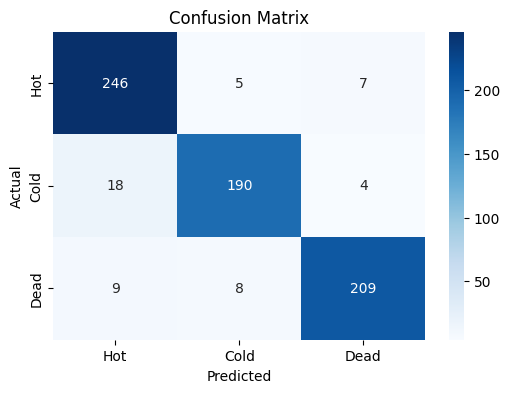

In [22]:
# Cell 7: Evaluate model

# Predict on test data
y_pred = lr_model.predict(X_test_tfidf)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["Hot", "Cold", "Dead"])
print("\nConfusion Matrix:")
print(cm)

# Optional: visualize confusion matrix
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hot","Cold","Dead"], yticklabels=["Hot","Cold","Dead"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


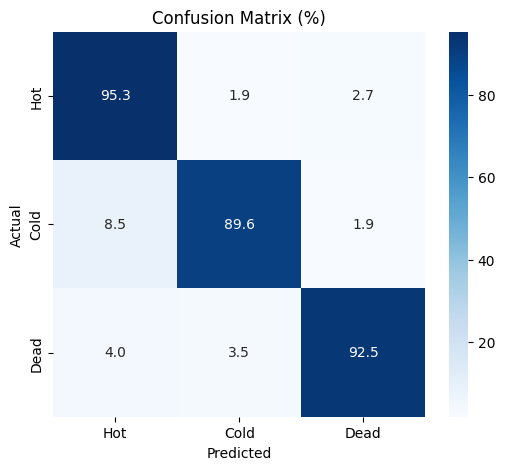

In [23]:
# Confusion matrix percentages
cm = confusion_matrix(y_test, y_pred, labels=["Hot", "Cold", "Dead"])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Hot","Cold","Dead"], yticklabels=["Hot","Cold","Dead"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%)")
plt.show()


/tmp/ipython-input-3987208959.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette="Set2")


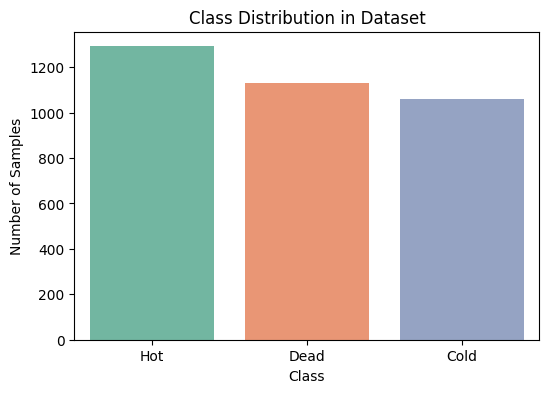

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette="Set2")
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


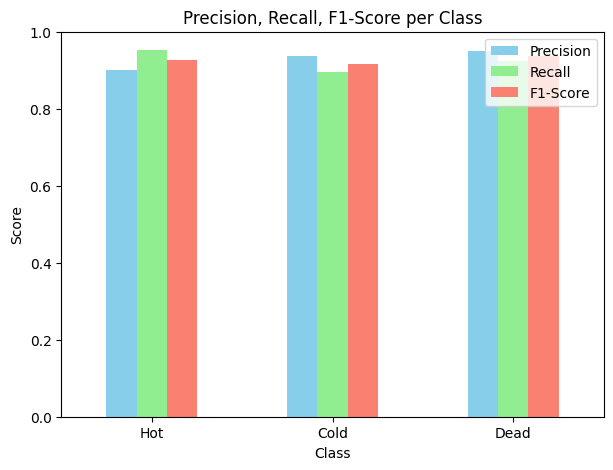

In [25]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=["Hot","Cold","Dead"])

metrics_df = pd.DataFrame({
    "Class": ["Hot","Cold","Dead"],
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
})

metrics_df.plot(x="Class", kind="bar", figsize=(7,5), color=["skyblue","lightgreen","salmon"])
plt.title("Precision, Recall, F1-Score per Class")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


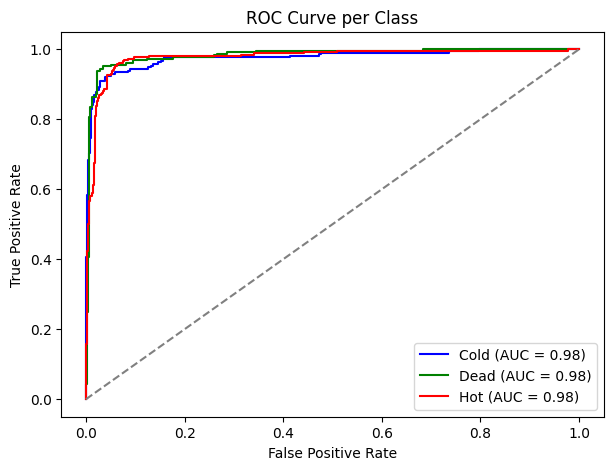

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Binarize labels
le = LabelEncoder()
y_test_bin = label_binarize(le.fit_transform(y_test), classes=[0,1,2])
y_pred_prob = lr_model.predict_proba(X_test_tfidf)

# Plot ROC per class
plt.figure(figsize=(7,5))
colors = ["blue", "green", "red"]
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_pred_prob[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.show()


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Convert TF-IDF to dense tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Map labels to integers
label_map_int = {"Hot":0, "Cold":1, "Dead":2}
y_train_tensor = torch.tensor([label_map_int[label] for label in y_train], dtype=torch.long)
y_test_tensor  = torch.tensor([label_map_int[label] for label in y_test], dtype=torch.long)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_tensor, y_train_tensor)
test_dataset  = TextDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [30]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train_tfidf.shape[1]  # number of TF-IDF features
output_dim = 3  # Hot, Cold, Dead
model = LogisticRegressionModel(input_dim, output_dim)


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [32]:
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


Epoch [1/30], Train Loss: 0.8828, Val Loss: 0.6809
Epoch [2/30], Train Loss: 0.5259, Val Loss: 0.4942
Epoch [3/30], Train Loss: 0.3597, Val Loss: 0.4014
Epoch [4/30], Train Loss: 0.2707, Val Loss: 0.3481
Epoch [5/30], Train Loss: 0.2159, Val Loss: 0.3132
Epoch [6/30], Train Loss: 0.1785, Val Loss: 0.2894
Epoch [7/30], Train Loss: 0.1518, Val Loss: 0.2732
Epoch [8/30], Train Loss: 0.1314, Val Loss: 0.2611
Epoch [9/30], Train Loss: 0.1156, Val Loss: 0.2514
Epoch [10/30], Train Loss: 0.1028, Val Loss: 0.2430
Epoch [11/30], Train Loss: 0.0921, Val Loss: 0.2376
Epoch [12/30], Train Loss: 0.0835, Val Loss: 0.2323
Epoch [13/30], Train Loss: 0.0759, Val Loss: 0.2288
Epoch [14/30], Train Loss: 0.0693, Val Loss: 0.2255
Epoch [15/30], Train Loss: 0.0637, Val Loss: 0.2229
Epoch [16/30], Train Loss: 0.0587, Val Loss: 0.2210
Epoch [17/30], Train Loss: 0.0543, Val Loss: 0.2195
Epoch [18/30], Train Loss: 0.0503, Val Loss: 0.2178
Epoch [19/30], Train Loss: 0.0468, Val Loss: 0.2169
Epoch [20/30], Train 

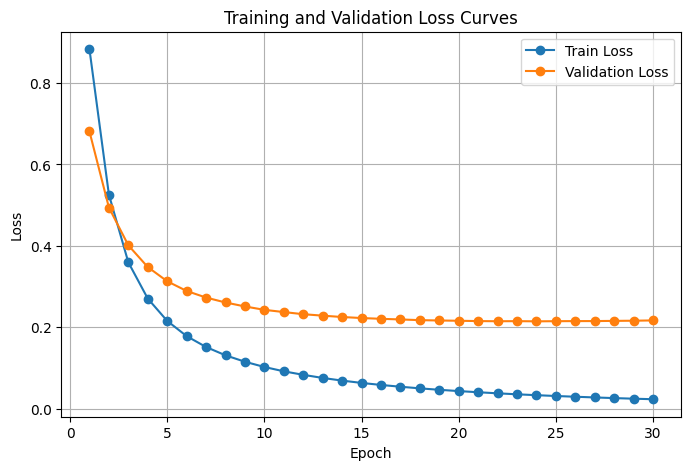

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1,num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1,num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


Test Accuracy: 0.9325

Classification Report:
              precision    recall  f1-score   support

        Cold       0.94      0.90      0.92       212
        Dead       0.95      0.95      0.95       226
         Hot       0.92      0.95      0.93       258

    accuracy                           0.93       696
   macro avg       0.93      0.93      0.93       696
weighted avg       0.93      0.93      0.93       696



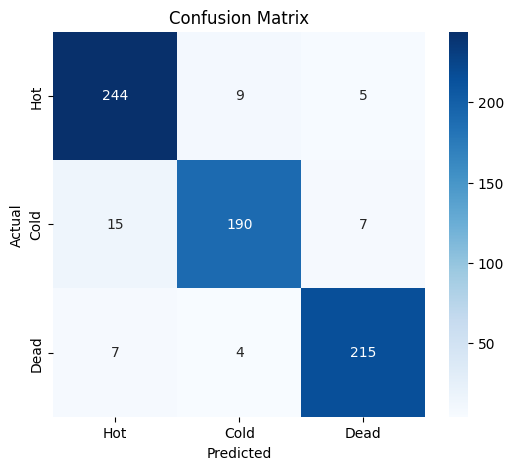

In [34]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Put model in eval mode
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Map integer labels back to class names
inv_label_map = {0:"Hot", 1:"Cold", 2:"Dead"}
y_true_labels = [inv_label_map[i] for i in y_true]
y_pred_labels = [inv_label_map[i] for i in y_pred]

# Accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Test Accuracy: {acc:.4f}")

# Precision, Recall, F1-score
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Optional: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=["Hot","Cold","Dead"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hot","Cold","Dead"], yticklabels=["Hot","Cold","Dead"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [4]:
# One-shot rebuild + save Best_model (self contained)
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import joblib

file_path = "dataset.csv"
encodings = ["utf-8", "latin1", "ISO-8859-1", "cp1252"]

df = None
for enc in encodings:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        print(f"Loaded dataset with encoding: {enc}")
        break
    except Exception as e:
        print(f"Failed with {enc}: {e}")

if df is None:
    raise RuntimeError("Could not load ds.csv with tried encodings.")

# Standardize column names
df.columns = [c.lower() for c in df.columns]
if "phrase" not in df or "sentiment" not in df:
    raise ValueError("Expected columns 'phrase' and 'sentiment' in ds.csv")

# Map labels to final classes
label_map = {
    "positive": "Hot",
    "positive'": "Hot",
    "negative": "Dead",
    "neutral": "Cold",
}
df["sentiment"] = df["sentiment"].replace(label_map)

# Keep only expected labels
valid_labels = set(label_map.values())
df = df[df["sentiment"].isin(valid_labels)].copy()
df["phrase"] = df["phrase"].fillna("")

X_all = df["phrase"]
y_all = df["sentiment"]

# ====== Train/Test Split for Evaluation ======
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Build and train pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words=None)),
    ("classifier", LogisticRegression(max_iter=500, solver="lbfgs", multi_class="auto", random_state=42)),
])

pipeline.fit(X_train, y_train)

# ====== Evaluation ======
y_pred = pipeline.predict(X_test)

print("\n===== Evaluation Metrics =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Refit on full dataset to save final Best_model
pipeline.fit(X_all, y_all)

Best_model = {
    "model_name": "Best_model",
    "pipeline": pipeline,
    "label_map": label_map,
    "classes": pipeline.classes_,
}

output_path = "Best_model.pkl"
joblib.dump(Best_model, output_path)
print(f"\nSaved {output_path} (fitted pipeline + label map + classes). Ready for inference.")


Loaded dataset with encoding: utf-8

===== Evaluation Metrics =====
Accuracy: 0.9224

Classification Report:
              precision    recall  f1-score   support

        Cold       0.93      0.89      0.91       212
        Dead       0.96      0.92      0.94       226
         Hot       0.88      0.95      0.92       258

    accuracy                           0.92       696
   macro avg       0.93      0.92      0.92       696
weighted avg       0.92      0.92      0.92       696


Confusion Matrix:
[[189   2  21]
 [  8 207  11]
 [  6   6 246]]

Saved Best_model.pkl (fitted pipeline + label map + classes). Ready for inference.


In [5]:
# ===== Inference / Prediction Cell =====
import joblib

# Load the saved model
model_path = "Best_model.pkl"
best_model = joblib.load(model_path)

pipeline = best_model["pipeline"]
classes = best_model["classes"]

print("Loaded Best_model successfully!")

# ---- Test samples ----
sample_texts = [
    "I'm intrested in buying.",
    "can i get a job",
    "i will buy in future."
]

# Prediction
preds = pipeline.predict(sample_texts)

print("\n===== Inference Results =====")
for text, pred in zip(sample_texts, preds):
    print(f"Text: {text}\n → Prediction: {pred}\n")


Loaded Best_model successfully!

===== Inference Results =====
Text: I'm intrested in buying.
 → Prediction: Cold

Text: can i get a job
 → Prediction: Dead

Text: i will buy in future.
 → Prediction: Dead

